<a href="https://colab.research.google.com/github/gina886/Analyzing-Historical-Stock/blob/main/ML_assignment2_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, recall_score, f1_score

# 1. load and preprocess data
df = pd.read_csv("Titanic.csv")


# print the shape of the dataset to see the number of rows (samples) and columns (features)
print("Dataset shape:", df.shape)


# show number of rows and columns

print(df.head() )

# Check for missing values in each column
print(df.isnull().sum())
print("\nTarget distribution (Survived):")
print(df['Survived'].value_counts())



# Drop columns that are not relevant for prediction
# 'PassengerId' is just an identifier
# 'Name' is text and not used directly in modeling
# 'Ticket' is also text, irrelevant for survival prediction
# 'Cabin' has 687 missing values
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)





Dataset shape: (891, 12)
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name  Gender   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8

In [3]:

# 2. Identify feature types
# Separate features (X) and target (y)
# X: all columns except the target
# y: the target column 'Survive

target = 'Survived'
X = df.drop(target, axis=1)
y = df[target]

#this selects columns with numeric data types (int, float)
# these features will usually require scaling and missing value imputation
nf = X.select_dtypes(include=np.number).columns.tolist()

# identify categorical features
cf = X.select_dtypes(include=['object']).columns.tolist()

In [4]:
# 3. create ColumnTransformer for preoprocessing

''' Here,i need to treat different types of features differently.
Numerical features require missing value imputation and normalization.
Categorical features require missing value imputation and one-hot encoding..
1. imputes missing values with the median in the numerical features
2. imputes missing values with the mode in the categorical features '''

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()) #scale numeric features to mean=0, std=1
    ]), nf),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))# one-hot encode cat_features
    ]), cf)
])


In [5]:
# 4. splits the data into 80% training and 20% testing sets
#x1=x_train, x2=x_test,y1=y_train, y2= y_test

X1, X2, y1, y2 = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
'''5.# Train three different classification models:
# 1. Logistic Regression
# 2. Decision Tree
# 3. Random Forest

# Each model's pipeline consists of two steps:
# (1) The preprocessor defined in the previous step
# (2) The specific classifier '''

#logistic regression pipeline
# max_iter=1000 to ensure iterative convergence
# random_state=42 to fix randomness and ensure repeatable results

lr = Pipeline([('preprocessor', preprocessor), ('classifier', LogisticRegression(max_iter=1000, random_state=42))])

#decision tree pipeline
# max_depth=3 limits the maximum depth of the tree to prevent overfitting
dt = Pipeline([('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier(max_depth=3, random_state=42))])

# random Forest pipeline
# n_estimators=100 The random forest contains 100 trees
rf = Pipeline([('preprocessor', preprocessor), ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])


## put the three models into the dictionary to facilitate subsequent cycle training and evaluation
models = {'Logistic Regression': lr, 'Decision Tree': dt, 'Random Forest': rf}

In [7]:
# 6. train and predict
## train each model and then make predictions on the test set.
# calculate various model evaluation metrics: Accuracy, Recall, and F1-score.
# output a classification report and confusion matrix.

'''accuracy = the proportion of correctly predicted examples
Recall = the proportion of correctly predicted positive examples
F1-score = the harmonic mean of precision and recall'''

y_preds = {}
acc = {} #accuracy
rec = {} # recall
f1_scores = {}
cv_scores = {}
#loop through three models in the dictionary
for key, model in models.items():

  #training the model on the training sets
    model.fit(X1, y1)

    #make predictions on the test set
    y_pred = model.predict(X2)

    #save the results
    y_preds[key] = y_pred
    acc[key] = accuracy_score(y2, y_pred)
    rec[key] = recall_score(y2, y_pred)
    f1_scores[key] = f1_score(y2, y_pred)

     #calculate the average accuracy using 5-fold cross validation
    cv_score = cross_val_score(model, X, y, cv=5, scoring='accuracy', n_jobs=-1)
    cv_scores[key] = cv_score.mean()

    #print the results of each model
    print(f"\n{key}")
    print(f"Accuracy: {acc[key]:.2f}, Recall: {rec[key]:.2f}, F1: {f1_scores[key]:.2f}")
    print(f"Cross-validation Accuracy: {cv_scores[key]:.2f} (±{cv_score.std():.2f})")

    #output a more detailed classification report
    print(classification_report(y2, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y2, y_pred))





Logistic Regression
Accuracy: 0.81, Recall: 0.74, F1: 0.76
Cross-validation Accuracy: 0.79 (±0.02)
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       105
           1       0.79      0.74      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

Confusion Matrix:
[[90 15]
 [19 55]]

Decision Tree
Accuracy: 0.80, Recall: 0.69, F1: 0.74
Cross-validation Accuracy: 0.81 (±0.01)
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       105
           1       0.80      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179

Confusion Matrix:
[[92 13]
 [23 51]]

Random Forest
Accuracy: 0.82, Recall: 0.76, F1: 0.78
Cross-validation Accurac

In [8]:
# 7. feature analysis
# For Logistic Regression and tree-based models, we want to see which features are most important
# This helps understand the model's decisions and interpretability
# Extract categorical feature names after one-hot encoding from the pipeline

cat_encoder = lr.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']

# Combine numeric feature names and one-hot encoded categorical feature names
all_features = nf + list(cat_encoder.get_feature_names_out(cf))

# Logistic Regression assigns a coefficient to each feature
# Positive coefficient -> feature increases chance of survival
# Negative coefficient -> feature decreases chance of survival

coef_df = pd.DataFrame({'Feature': all_features,
                        'Coefficient': lr.named_steps['classifier'].coef_[0]})
print("\nLogistic Regression Coefficients:")
print(coef_df.sort_values('Coefficient', ascending=False))

# random forest feature importances
rf_importances = rf.named_steps['classifier'].feature_importances_
rf_feat_df = pd.DataFrame({'Feature': all_features, 'Importance': rf_importances})

print("\nRandom Forest Feature Importances:")
#sort features by importance in descending order
print(rf_feat_df.sort_values('Importance', ascending=False))

# decision tree feature importances
dt_importances = dt.named_steps['classifier'].feature_importances_
dt_feat_df = pd.DataFrame({'Feature': all_features, 'Importance': dt_importances})
print("\nDecision Tree Feature Importances:")
print(dt_feat_df.sort_values('Importance', ascending=False))


Logistic Regression Coefficients:
       Feature  Coefficient
4         Fare     0.128723
3        Parch    -0.085486
6   Embarked_Q    -0.111205
2        SibSp    -0.343765
1          Age    -0.393647
7   Embarked_S    -0.401304
0       Pclass    -0.777620
5  Gender_male    -2.592776

Random Forest Feature Importances:
       Feature  Importance
5  Gender_male    0.273316
4         Fare    0.272058
1          Age    0.252745
0       Pclass    0.078616
2        SibSp    0.052192
3        Parch    0.038490
7   Embarked_S    0.023095
6   Embarked_Q    0.009488

Decision Tree Feature Importances:
       Feature  Importance
5  Gender_male    0.605737
0       Pclass    0.209536
1          Age    0.075353
4         Fare    0.061240
2        SibSp    0.048135
3        Parch    0.000000
6   Embarked_Q    0.000000
7   Embarked_S    0.000000


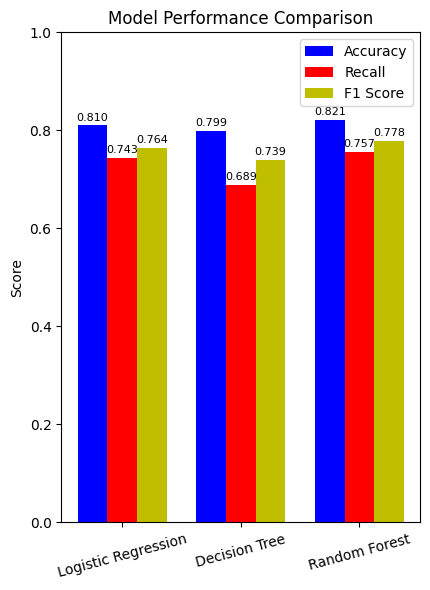

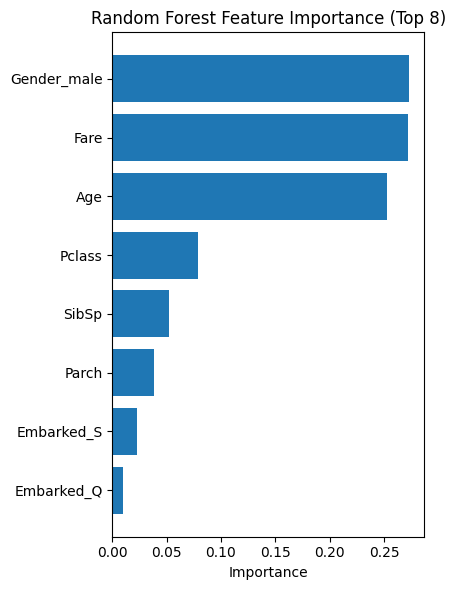

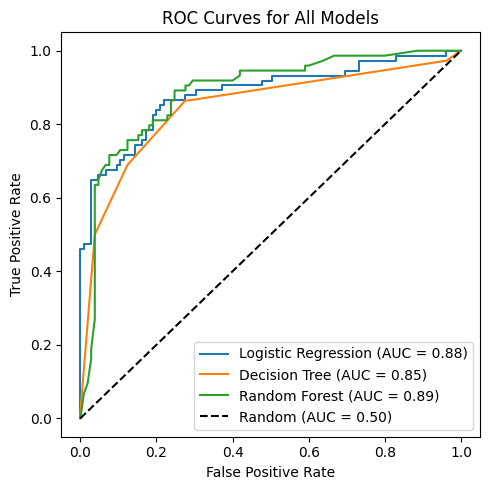

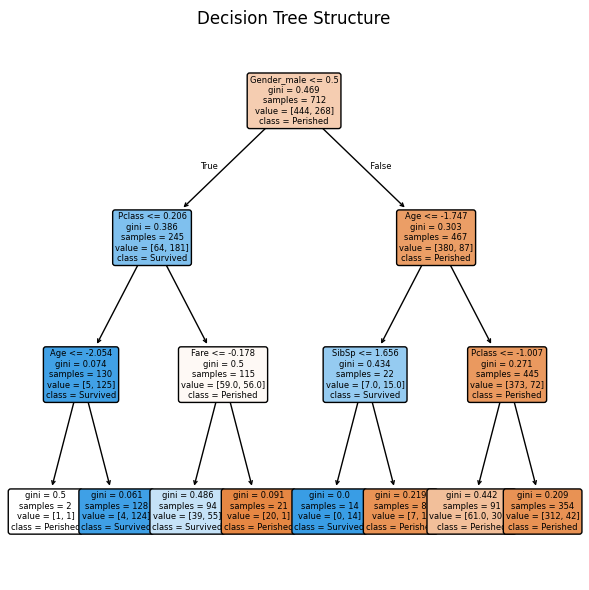

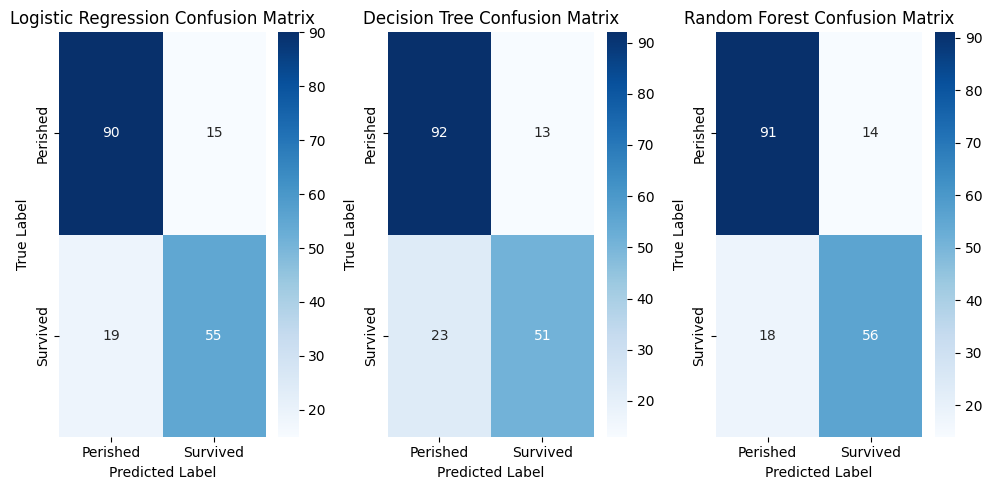

In [9]:
# 8. visualization - create multiple figures to avoid overcrowding
# figure 1: Model perdormance comparison

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)


# prepare data for plotting
models_list = list(acc.keys())
acc_values = list(acc.values())
rec_values = list(rec.values())
f1_values = list(f1_scores.values())

x_pos = np.arange(len(models_list))
width = 0.25 # width of each bar

#draw bars for Accuracy, Recall, and F1-score
plt.bar(x_pos - width, acc_values, width, label='Accuracy', color='b')
plt.bar(x_pos, rec_values, width, label='Recall', color='r')
plt.bar(x_pos + width, f1_values, width, label='F1 Score', color='y')

plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(x_pos, models_list, rotation=15)
plt.legend()
plt.ylim(0, 1)

# add value labels on bars
#loop through each index (i) and value (v) in the accuracy values
for i, v in enumerate(acc_values):           #align text to the center
    plt.text(i - width, v + 0.01, f'{v:.3f}', ha='center', fontsize=8)
#loop through each index (i) and value (v) in the recall values
for i, v in enumerate(rec_values):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=8)
#loop through each index (i) and value (v) in the f1-score values
for i, v in enumerate(f1_values):
    plt.text(i + width, v + 0.01, f'{v:.3f}', ha='center', fontsize=8)
plt.tight_layout()
plt.show()


# figure 2: Random Forest top 8 features
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 2)

# get indices of top 8 features by importance
top_indices = np.argsort(rf_importances)[-8:]

# Horizontal bar plot
plt.barh(range(len(top_indices)), rf_importances[top_indices])
plt.yticks(range(len(top_indices)), [all_features[i] for i in top_indices])
plt.title('Random Forest Feature Importance (Top 8)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


# figure 3: ROC Curves for All Models
plt.figure(figsize=(5, 5))
for name, model in models.items():
  # check if model supports probability prediction
    if hasattr(model, 'predict_proba'):
        try:
            y_prob = model.predict_proba(X2)[:, 1]# probability of positive class
            fpr, tpr, _ = roc_curve(y2, y_prob)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
        except Exception as e:
            print(f"Error generating ROC curve for {name}: {e}")

#diagonal line represents random guessing
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
plt.title('ROC Curves for All Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Figure 4: decision Tree
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_tree(dt.named_steps['classifier'], feature_names=all_features,
          class_names=['Perished','Survived'], filled=True, rounded=True, fontsize=6)
plt.title('Decision Tree Structure')
plt.tight_layout()
plt.show()

#Figure 5: Confusion Matrix
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
for i, (name, y_pred) in enumerate(y_preds.items()):
    cm = confusion_matrix(y2, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Perished', 'Survived'],
                yticklabels=['Perished', 'Survived'])
    axes[i].set_title(f'{name} Confusion Matrix')
    axes[i].set_ylabel('True Label')
    axes[i].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()